In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
#import datetime as dt
from datetime import datetime
 

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
#Create a Base
#reflect an existing database into a new model
Base = automap_base()
# reflect the tables 
Base.prepare(autoload_with=engine)  

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement=Base.classes.measurement 
Station = Base.classes.station

In [8]:
# Check the names of the columns in the table Measurement 
from sqlalchemy import inspect
inspector = inspect(engine)
cols=inspector.get_columns('measurement')
for c in cols:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Check the columns in the table Station
cols=inspector.get_columns('station')
for c in cols:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(recent_date)

2017-08-23


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.     

#Convert last date to date format
rd=datetime.strptime(recent_date,"%Y-%m-%d")

# Calculate the date one year from the last date in data set.
last_year=datetime(year=rd.year-1, month=rd.month, day=rd.day).date()
past_date= f'{last_year.year}-{last_year.month:02d}-{last_year.day:02d}'
print(past_date) 

2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores 
precip_12_months=session.query(Measurement.date,func.max(Measurement.prcp)). \
                        filter(Measurement.date.between(past_date , recent_date)). \
                        group_by(Measurement.date).order_by(Measurement.date).all()
print(precip_12_months)

[('2016-08-23', 1.79), ('2016-08-24', 2.28), ('2016-08-25', 0.21), ('2016-08-26', 0.04), ('2016-08-27', 0.18), ('2016-08-28', 2.07), ('2016-08-29', 0.9), ('2016-08-30', 0.05), ('2016-08-31', 2.46), ('2016-09-01', 0.02), ('2016-09-02', 0.19), ('2016-09-03', 1.0), ('2016-09-04', 0.74), ('2016-09-05', 0.18), ('2016-09-06', 1.0), ('2016-09-07', 1.35), ('2016-09-08', 0.22), ('2016-09-09', 0.35), ('2016-09-10', 1.16), ('2016-09-11', 0.6), ('2016-09-12', 1.04), ('2016-09-13', 1.2), ('2016-09-14', 6.7), ('2016-09-15', 3.35), ('2016-09-16', 0.61), ('2016-09-17', 0.36), ('2016-09-18', 0.42), ('2016-09-19', 0.25), ('2016-09-20', 0.43), ('2016-09-21', 1.02), ('2016-09-22', 0.75), ('2016-09-23', 0.94), ('2016-09-24', 0.27), ('2016-09-25', 0.04), ('2016-09-26', 1.02), ('2016-09-27', 1.0), ('2016-09-28', 0.08), ('2016-09-29', 1.49), ('2016-09-30', 0.38), ('2016-10-01', 1.02), ('2016-10-02', 0.61), ('2016-10-03', 0.46), ('2016-10-04', 3.46), ('2016-10-05', 0.81), ('2016-10-06', 0.07), ('2016-10-07', 0

In [14]:
# Save the query results as a Pandas DataFrame 
df=pd.DataFrame(precip_12_months,columns=['Date','Precipitation'])

#Set the index to the date column
df=df.set_index('Date', inplace=False)

#Sort database
precipitation_df=df.sort_index()
precipitation_df.head(5)

,Precipitation
Date,
2016-08-23,1.79
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18


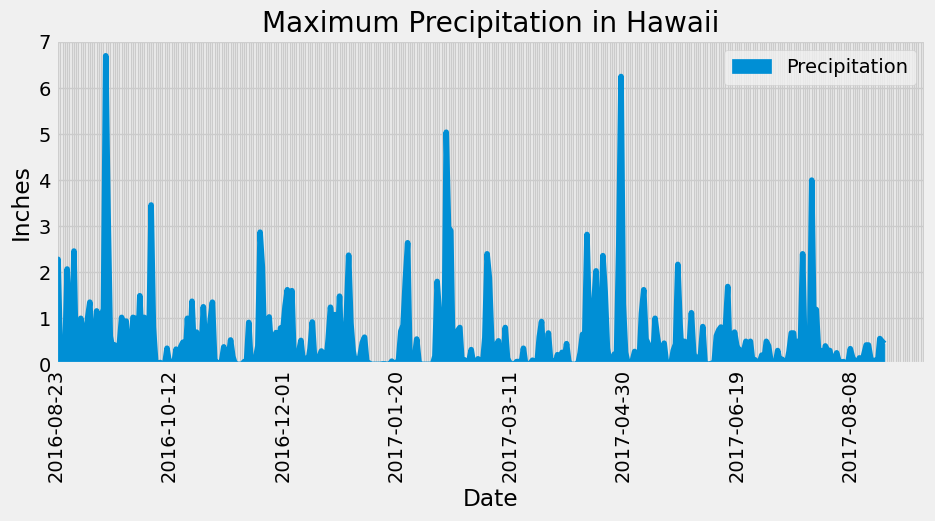

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.dates as mdates

precipitation_df.plot.area( y='Precipitation',figsize=(10,4))
plt.title('Maximum Precipitation in Hawaii')
plt.xlabel('Date')

ax = plt.gca()                  
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  #This functions were shared with me by one of my peers
ax.set_xlim(left=0)

plt.xticks(rotation='vertical')

plt.ylabel("Inches")
# Save the figure
plt.savefig("output/Max_prcp.png")

plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
print(precipitation_df.describe())

       Precipitation
count     366.000000
mean        0.520765
std         0.830728
min         0.000000
25%         0.040000
50%         0.250000
75%         0.672500
max         6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
total_stations=session.query(func.count(Station.station)).all()[0]
print(F"The database has {total_stations[0]} stations")

The database has 9 stations


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_list=session.query(Measurement.station,func.count(Measurement.prcp)).filter(Measurement.prcp > 0). \
                    group_by(Measurement.station). order_by(func.count(Measurement.prcp).desc()).all()
print(most_active_list)


[('USC00519281', 1973), ('USC00516128', 1937), ('USC00513117', 1765), ('USC00519523', 1191), ('USC00514830', 1114), ('USC00519397', 919), ('USC00511918', 534), ('USC00518838', 256), ('USC00517948', 229)]


In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

#Get the code of the station
most_active_station=(most_active_list[0])[0]

#Calculate the statistics for the past year
temperatures=session.query(Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs), \
                    func.avg(Measurement.tobs)). filter(Measurement.date >= past_date, \
                            Measurement.station == most_active_station).all()

print(f"Station {most_active_station} registered temperatures of \
{temperatures[0][1]} (min),{temperatures[0][2]} (max) and {round(temperatures[0][3],2)} (average) \
during the year between {past_date} and {recent_date} ") 


Station USC00519281 registered temperatures of 59.0 (min),83.0 (max) and 73.11 (average) during the year between 2016-08-23 and 2017-08-23 


In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_12=session.query(Measurement.date,Measurement.tobs). \
                    filter(Measurement.date.between(past_date , recent_date), \
                           Measurement.station ==most_active_station). \
                           order_by(Measurement.date).all()
print(most_active_12)

[('2016-08-23', 77.0), ('2016-08-24', 77.0), ('2016-08-25', 80.0), ('2016-08-26', 80.0), ('2016-08-27', 75.0), ('2016-08-28', 73.0), ('2016-08-29', 78.0), ('2016-08-30', 77.0), ('2016-08-31', 78.0), ('2016-09-01', 80.0), ('2016-09-02', 80.0), ('2016-09-03', 78.0), ('2016-09-04', 78.0), ('2016-09-05', 78.0), ('2016-09-06', 73.0), ('2016-09-07', 74.0), ('2016-09-08', 80.0), ('2016-09-09', 79.0), ('2016-09-10', 77.0), ('2016-09-11', 80.0), ('2016-09-12', 76.0), ('2016-09-13', 79.0), ('2016-09-14', 75.0), ('2016-09-15', 79.0), ('2016-09-16', 78.0), ('2016-09-17', 79.0), ('2016-09-18', 78.0), ('2016-09-19', 78.0), ('2016-09-20', 76.0), ('2016-09-21', 74.0), ('2016-09-22', 77.0), ('2016-09-23', 78.0), ('2016-09-24', 79.0), ('2016-09-25', 79.0), ('2016-09-26', 77.0), ('2016-09-27', 80.0), ('2016-09-28', 78.0), ('2016-09-29', 78.0), ('2016-09-30', 78.0), ('2016-10-01', 77.0), ('2016-10-02', 79.0), ('2016-10-03', 79.0), ('2016-10-04', 79.0), ('2016-10-05', 79.0), ('2016-10-06', 75.0), ('2016-10

In [24]:
#Save the query results as a Pandas DataFrame
df1=pd.DataFrame(most_active_12,columns=['Date','Temperature'])

df1=df1.set_index('Date', inplace=False)
precipitation_most_active=df1.sort_index()
len(precipitation_most_active)


352

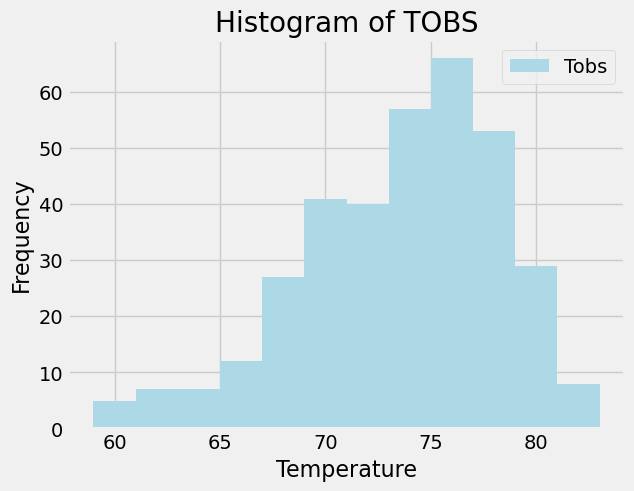

In [25]:

# Plot the result using an histogram 
plt.hist(x=precipitation_most_active['Temperature'], bins=12, color='lightblue', histtype='bar') 
plt.xlabel('Temperature', fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.legend(['Tobs'])
plt.title('Histogram of TOBS',fontsize=20)

# Save the figure
plt.savefig("output/Hist_tobs.png")

#Plot the graph
plt.show()

# Close session

In [26]:
# Close Session
session.close()